# 🚇 지하철 사고 분석 요약

## 0. 데이터 불러오기

In [ ]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import platform
# 파일 경로에 맞게 수정
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding="cp949")
df1 = pd.read_csv("CARD_SUBWAY_MONTH_202504.csv", encoding='utf-8', header=1)
df1.columns = ['사용일자','노선명','역명','승차총승객수','하차총승객수','등록일자', '0']
df1 = df1.drop(columns=['0'])


In [3]:

def improved_normalize_station_name(name):
    name = str(name)
    name = re.sub(r'\(.*?\)', '', name)
    name = name.replace('역', '').strip()
    return name


In [4]:

df1['총유동인구'] = pd.to_numeric(df1['승차총승객수'], errors='coerce') + pd.to_numeric(df1['하차총승객수'], errors='coerce')
df1['정규역명'] = df1['역명'].apply(improved_normalize_station_name)
accident_df['정규역명'] = accident_df['발생역'].apply(improved_normalize_station_name)

# 평균 유동인구 계산
daily_counts = df1.groupby('정규역명').size().reset_index(name='일수')
total_pop = df1.groupby('정규역명')['총유동인구'].sum().reset_index(name='총유동인구')
average_pop = pd.merge(total_pop, daily_counts, on='정규역명')
average_pop['평균유동인구'] = average_pop['총유동인구'] / average_pop['일수']


In [5]:

accident_counts = accident_df['정규역명'].value_counts().reset_index()
accident_counts.columns = ['역명', '사고건수']
accident_with_avg = pd.merge(accident_counts, average_pop, left_on='역명', right_on='정규역명', how='left')
accident_with_avg['사고비율'] = accident_with_avg['사고건수'] / accident_with_avg['평균유동인구']
accident_with_avg_sorted = accident_with_avg.sort_values(by='사고비율', ascending=False)


In [6]:

accident_type_counts = accident_df.groupby(['정규역명', '사고유형']).size().reset_index(name='사고건수')
accident_type_merged = pd.merge(accident_type_counts, average_pop, left_on='정규역명', right_on='정규역명', how='left')
accident_type_merged['사고비율'] = accident_type_merged['사고건수'] / accident_type_merged['평균유동인구']
accident_type_sorted = accident_type_merged.sort_values(by='사고건수', ascending=False)


In [7]:
import pandas as pd

# 데이터 불러오기
time_df = pd.read_csv("서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv", encoding='cp949')
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding='cp949')

# 사고 시간대 추출
accident_df['시간대'] = pd.to_datetime(accident_df['발생시간'], errors='coerce').dt.hour
accident_by_hour = accident_df['시간대'].value_counts().reset_index()
accident_by_hour.columns = ['시간대', '사고건수']

# 시간대 유동인구 합계 계산
ride_df = time_df[time_df['구분'] == '승차']
exit_df = time_df[time_df['구분'] == '하차']
time_columns = [col for col in time_df.columns if '시' in col and '-' in col]

# 시간대별 총 유동인구 합계 (승차 + 하차)
ride_sum = ride_df[time_columns].sum()
exit_sum = exit_df[time_columns].sum()
total_time_sum = ride_sum + exit_sum

# 시간대 추출: '08시-09시' → 8
hour_labels = total_time_sum.index.str.extract(r'(\d+)').astype(int)[0]
total_by_hour = pd.DataFrame({
    '시간대': hour_labels,
    '총유동인구': total_time_sum.values
})

# 날짜 수 확인 (날짜 컬럼이 없을 수도 있으므로 예외 처리)
if '날짜' in time_df.columns:
    unique_dates = time_df['날짜'].nunique()
else:
    # 월 단위라면 대략 30일 * 12개월
    unique_dates = 365

# 평균 유동인구 계산
total_by_hour['평균유동인구'] = total_by_hour['총유동인구'] / unique_dates

# 병합 및 사고비율 계산
hourly_avg_merged = pd.merge(accident_by_hour, total_by_hour[['시간대', '평균유동인구']], on='시간대', how='left')
hourly_avg_merged['사고비율'] = hourly_avg_merged['사고건수'] / hourly_avg_merged['평균유동인구']

# 사고건수 기준 정렬
hourly_avg_sorted = hourly_avg_merged.sort_values(by='사고건수', ascending=False)

# 결과 확인
print(hourly_avg_sorted.head(10))


    시간대  사고건수         평균유동인구      사고비율
0   8.0   337  853605.467213  0.000395
1  18.0   264  885995.142077  0.000298
2  17.0   188  702477.500000  0.000268
3  16.0   178  550685.685792  0.000323
4  15.0   162  478554.497268  0.000339
5   9.0   156  569898.308743  0.000274
6   7.0   134  505060.286885  0.000265
7  14.0   127  436152.631148  0.000291
8  12.0   125  413949.374317  0.000302
9  11.0   121  389130.549180  0.000311


C:\Users\김효준\AppData\Local\Temp\ipykernel_4504\4260809057.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  accident_df['시간대'] = pd.to_datetime(accident_df['발생시간'], errors='coerce').dt.hour


## 1. 평균 유동 인구 대비 사고 비율 TOP10

In [8]:
accident_with_avg_sorted[['역명', '사고건수', '평균유동인구', '사고비율']].head(10)

,역명,사고건수,평균유동인구,사고비율
0,동대문사문화공원,99,25860.700000,0.003828
97,동작,7,4522.116667,0.001548
50,오금,14,10098.900000,0.001386
9,군자,35,26513.383333,0.001320
5,충무로,43,33315.866667,0.001291
43,신설동,15,13864.466667,0.001082
11,동대문,33,32455.700000,0.001017
35,약수,17,16733.100000,0.001016
7,종로3가,38,37858.500000,0.001004
13,창동,28,28183.566667,0.000993


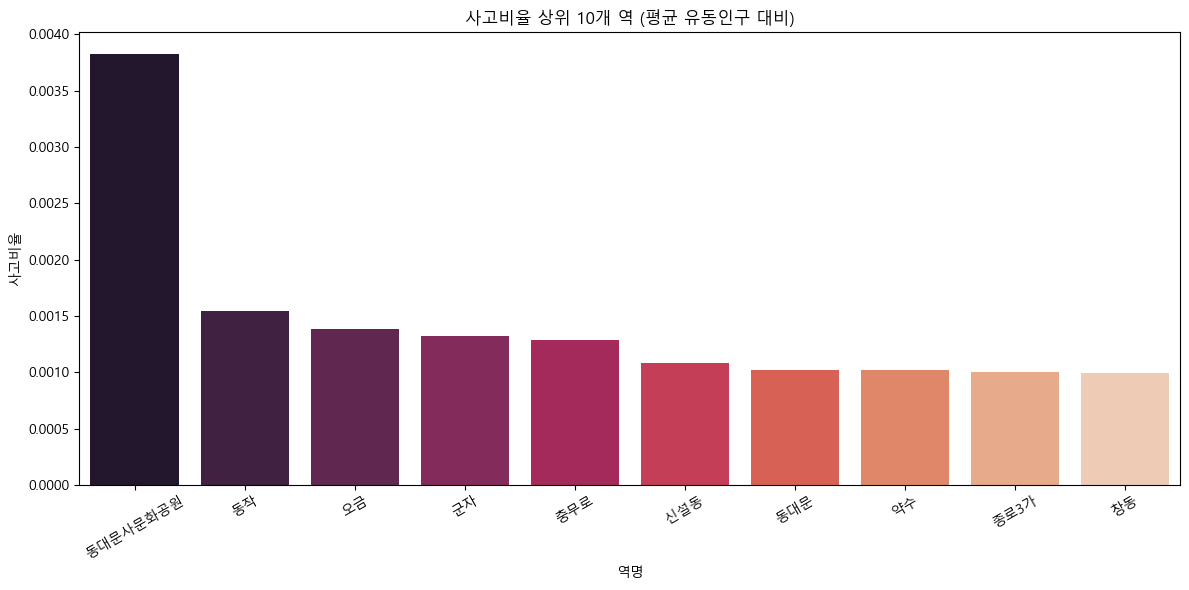

In [28]:
accident_ratio_top10 = accident_with_avg_sorted.sort_values(by='사고비율', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=accident_ratio_top10,
    x='역명',
    y='사고비율',
    palette='rocket'
)
plt.title('사고비율 상위 10개 역 (평균 유동인구 대비)')
plt.xlabel('역명')
plt.ylabel('사고비율')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 2. 사고건수 TOP10 (사고비율 포함)

In [9]:
accident_with_avg_sorted.sort_values(by='사고건수', ascending=False)[['역명', '사고건수', '평균유동인구', '사고비율']].head(10)

,역명,사고건수,평균유동인구,사고비율
0,동대문사문화공원,99,25860.700000,0.003828
1,사당,60,70994.216667,0.000845
2,신도림,49,56024.333333,0.000875
3,고속터미널,47,55957.455556,0.000840
4,교대,44,47287.300000,0.000930
5,충무로,43,33315.866667,0.001291
6,서울,40,45606.213333,0.000877
7,종로3가,38,37858.500000,0.001004
8,천호,36,38880.050000,0.000926
9,군자,35,26513.383333,0.001320


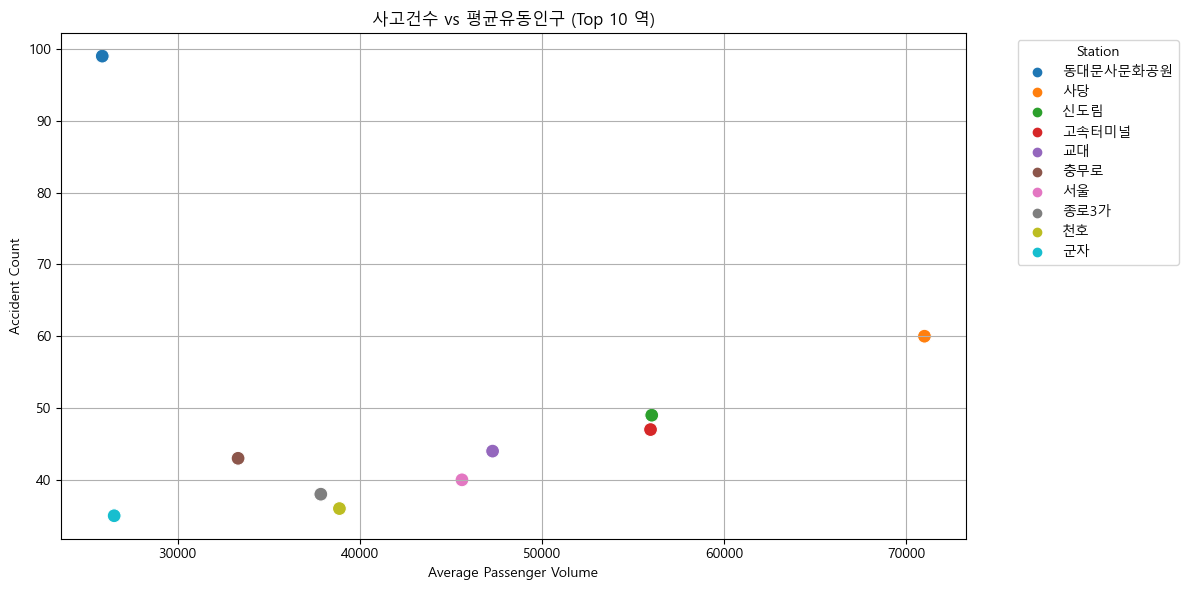

In [27]:
accident_station_top10 = accident_with_avg_sorted.sort_values(by='사고건수', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=accident_station_top10,
    x='평균유동인구',
    y='사고건수',
    hue='역명',
    palette='tab10',
    s=100
)
plt.title('사고건수 vs 평균유동인구 (Top 10 역)')
plt.xlabel('Average Passenger Volume')
plt.ylabel('Accident Count')
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. 사고 유형별 TOP10

In [10]:
accident_type_sorted[['정규역명', '사고유형', '사고건수', '평균유동인구', '사고비율']].head(10)

,정규역명,사고유형,사고건수,평균유동인구,사고비율
214,동대문사문화공원,발빠짐,48,25860.700000,0.001856
218,동대문사문화공원,출입문관련,38,25860.700000,0.001469
83,교대,출입문관련,23,47287.300000,0.000486
489,신촌,발빠짐,21,41292.933333,0.000509
344,사당,출입문관련,21,70994.216667,0.000296
55,고속터미널,발빠짐,21,55957.455556,0.000375
705,천호,출입문관련,20,38880.050000,0.000514
107,군자,출입문관련,20,26513.383333,0.000754
725,충무로,발빠짐,19,33315.866667,0.000570
467,신도림,출입문관련,18,56024.333333,0.000321


## 4. 시간대별 평균 유동인구 기반 사고율

In [11]:
hourly_avg_sorted[['시간대', '사고건수', '평균유동인구', '사고비율']].head(10)

,시간대,사고건수,평균유동인구,사고비율
0,8.0,337,853605.467213,0.000395
1,18.0,264,885995.142077,0.000298
2,17.0,188,702477.500000,0.000268
3,16.0,178,550685.685792,0.000323
4,15.0,162,478554.497268,0.000339
5,9.0,156,569898.308743,0.000274
6,7.0,134,505060.286885,0.000265
7,14.0,127,436152.631148,0.000291
8,12.0,125,413949.374317,0.000302
9,11.0,121,389130.549180,0.000311


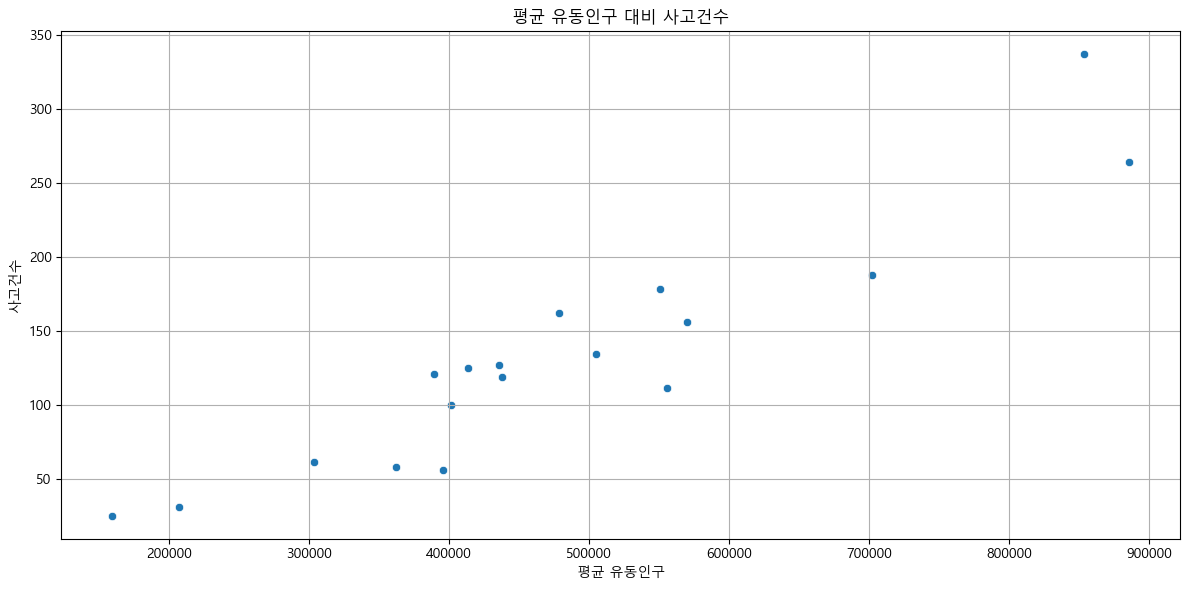

In [25]:
# Visualization for hourly average
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=hourly_avg_sorted,
    x='평균유동인구',
    y='사고건수'
)
plt.title('평균 유동인구 대비 사고건수')
plt.xlabel('평균 유동인구')
plt.ylabel('사고건수')
plt.grid(True)
plt.tight_layout()
plt.show()


c:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


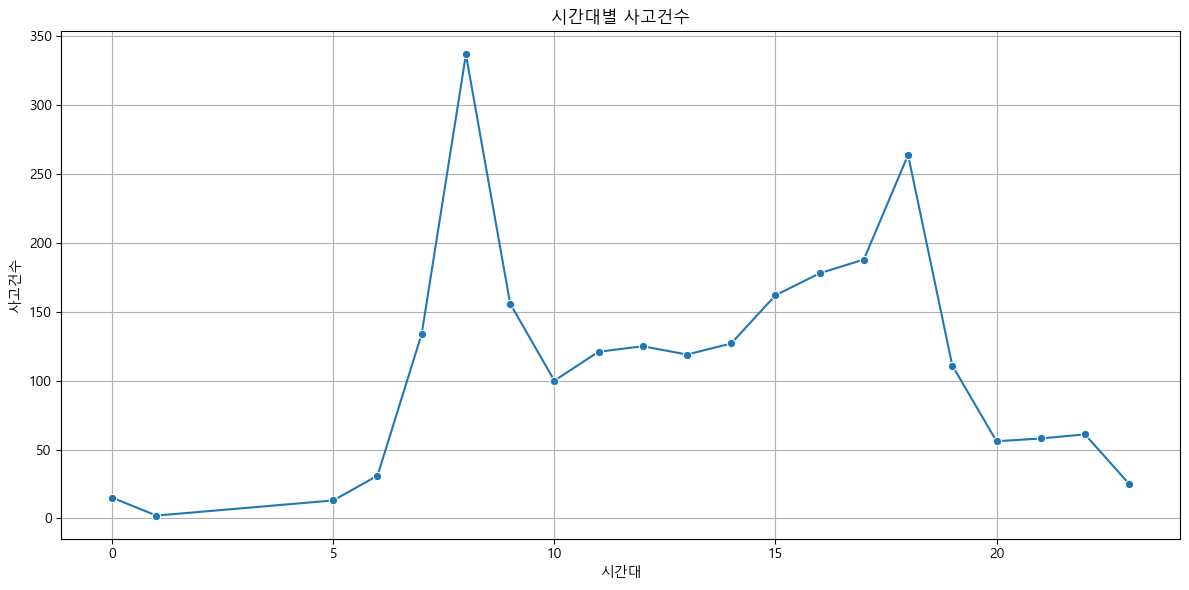

In [24]:

# Visualization for hourly average
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_avg_sorted,
    x='시간대',
    y='사고건수',
    marker='o'
)
plt.title('시간대별 사고건수')
plt.xlabel('시간대')
plt.ylabel('사고건수')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:

import pandas as pd
import re

# 사고 데이터 불러오기
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding="cp949")

# 정규역명 처리
def improved_normalize_station_name(name):
    name = str(name)
    name = re.sub(r'\(.*?\)', '', name)
    name = name.replace('역', '').strip()
    return name

accident_df['정규역명'] = accident_df['발생역'].apply(improved_normalize_station_name)

In [14]:

# 사고유형 전체 건수
type_total = accident_df['사고유형'].value_counts().reset_index()
type_total.columns = ['사고유형', '전체사고건수']

# 역별 사고유형 건수
type_by_station = accident_df.groupby(['정규역명', '사고유형']).size().reset_index(name='사고건수')

# 전체 사고유형 기준 비율
type_by_station = pd.merge(type_by_station, type_total, on='사고유형', how='left')


In [15]:

# 사고건수 상위 10개 역
top10_stations = accident_df['정규역명'].value_counts().head(10).index.tolist()
type_top10_stations = type_by_station[type_by_station['정규역명'].isin(top10_stations)]
type_top10_stations.iloc[:, :3]

,정규역명,사고유형,사고건수
55,고속터미널,발빠짐,21
56,고속터미널,승강설비관련,7
57,고속터미널,역구내 사고,6
58,고속터미널,열차내 사고,5
59,고속터미널,출입문관련,8
78,교대,기타,1
79,교대,발빠짐,2
80,교대,승강설비관련,1
81,교대,역구내 사고,10
82,교대,열차내 사고,7


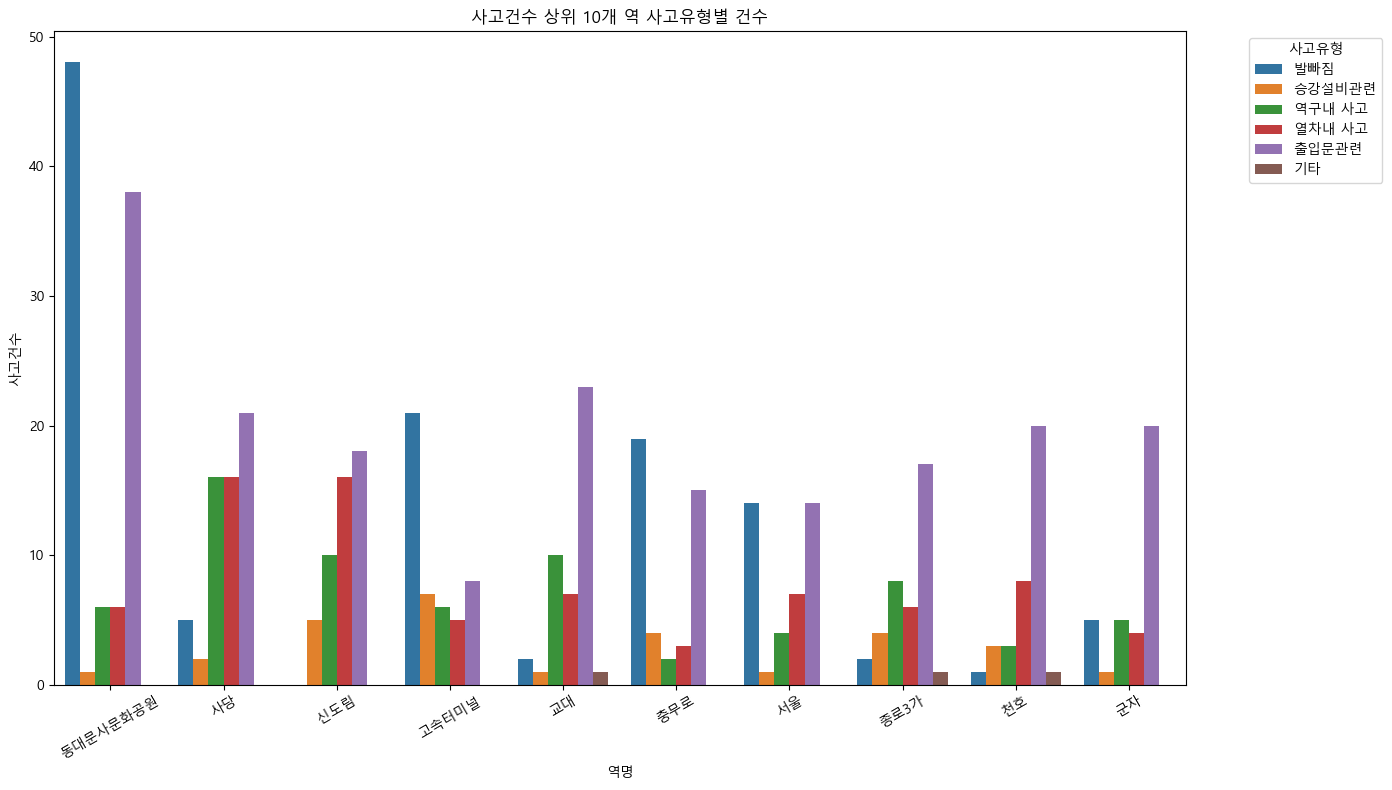

In [19]:
# Top 10 stations with the most accidents
accident_top10 = accident_df['정규역명'].value_counts().head(10).reset_index()
accident_top10.columns = ['station', 'total_accidents']

# Merge with accident type statistics
type_top10_base = type_by_station[type_by_station['정규역명'].isin(accident_top10['station'])]
type_top10_stations = pd.merge(type_top10_base, accident_top10, left_on='정규역명', right_on='station', how='left')
type_top10_stations = type_top10_stations.sort_values(by=['total_accidents', '정규역명'], ascending=[False, True])

# Output preview
type_top10_stations.iloc[:, :4]

# Visualization (bar chart)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import platform

# Set Korean font
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:  # Linux (assumes NanumGothic is installed)
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=type_top10_stations,
    x='정규역명',
    y='사고건수',
    hue='사고유형'
)
plt.title('사고건수 상위 10개 역 사고유형별 건수')
plt.xlabel('역명')
plt.ylabel('사고건수')
plt.xticks(rotation=30)
plt.legend(title='사고유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv("서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv", encoding='cp949')

# 날짜 컬럼을 datetime으로 변환
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

# 월 컬럼 생성
df['월'] = df['날짜'].dt.month

# 월별로 나누기 (딕셔너리 형태: {1: 1월 데이터프레임, 2: 2월 데이터프레임, ..., 12: 12월 데이터프레임})
monthly_data = {month: df[df['월'] == month] for month in sorted(df['월'].unique())}

# 예시: 1월 데이터 확인
monthly_data[2]


,연번,날짜,호선,역번호,역명,구분,06시 이전,06시-07시,07시-08시,08시-09시,...,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,24시 이후,월
16864,16865,2024-02-01,1호선,150,서울역,승차,316,511,1695,2766,...,3667,6765,9441,4326,2925,2838,1848,849,117,2
16865,16866,2024-02-01,1호선,150,서울역,하차,252,1963,4684,10427,...,2684,3040,3220,1861,1379,1176,886,354,129,2
16866,16867,2024-02-01,1호선,151,시청,승차,83,152,287,293,...,1988,3839,7287,2672,2329,2353,1296,483,41,2
16867,16868,2024-02-01,1호선,151,시청,하차,189,902,3362,8938,...,815,920,1128,481,303,301,200,107,38,2
16868,16869,2024-02-01,1호선,152,종각,승차,127,148,231,359,...,2747,6164,10258,4233,3736,3914,2937,1194,76,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32635,32636,2024-02-29,8호선,2826,수진,하차,23,87,125,313,...,400,441,641,469,337,298,245,199,84,2
32636,32637,2024-02-29,8호선,2827,모란,승차,85,121,347,443,...,639,603,533,326,244,212,146,176,64,2
32637,32638,2024-02-29,8호선,2827,모란,하차,18,113,187,511,...,292,308,484,271,202,165,131,106,143,2
32638,32639,2024-02-29,8호선,2828,남위례,승차,69,264,905,1080,...,430,697,852,319,261,262,211,122,43,2


In [7]:
import pandas as pd

# 유동인구 파일 로드
df = pd.read_csv("서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv", encoding='cp949')
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
df['월'] = df['날짜'].dt.month

# 시간대 컬럼
time_columns = [col for col in df.columns if '시' in col and '-' in col]

# 월별 유동인구 총합
monthly_data = {month: df[df['월'] == month] for month in sorted(df['월'].unique())}
monthly_passenger_stats = {}
for month, mdf in monthly_data.items():
    ride = mdf[mdf['구분'] == '승차'][time_columns].sum()
    exit = mdf[mdf['구분'] == '하차'][time_columns].sum()
    total = ride + exit
    monthly_passenger_stats[month] = total.sum()

monthly_passenger_stats = pd.Series(monthly_passenger_stats, name='총 유동인구')
days_per_month = df.groupby('월')['날짜'].nunique()
monthly_avg_passenger = monthly_passenger_stats / days_per_month
monthly_avg_passenger.name = '일평균 유동인구'

# 사고 데이터 로드
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding='cp949')
accident_df['발생일자'] = pd.to_datetime(accident_df['발생일자'], errors='coerce')
accident_df['월'] = accident_df['발생일자'].dt.month
monthly_accidents = accident_df['월'].value_counts().sort_index()

# 사고율 계산
monthly_accident_rate = monthly_accidents / monthly_avg_passenger
monthly_accident_rate.name = '사고율'

# 결과 병합
monthly_summary = pd.concat([
    monthly_accidents.rename('사고건수'),
    monthly_avg_passenger,
    monthly_accident_rate
], axis=1)
monthly_summary.astype(int)


,사고건수,일평균 유동인구,사고율
1,229,8264478,0
2,145,8102379,0
3,168,8796596,0
4,167,9067689,0
5,225,8908730,0
6,213,8547298,0
7,253,8603577,0
8,229,8092539,0
9,188,8114148,0
10,194,8811038,0


달별로 사고

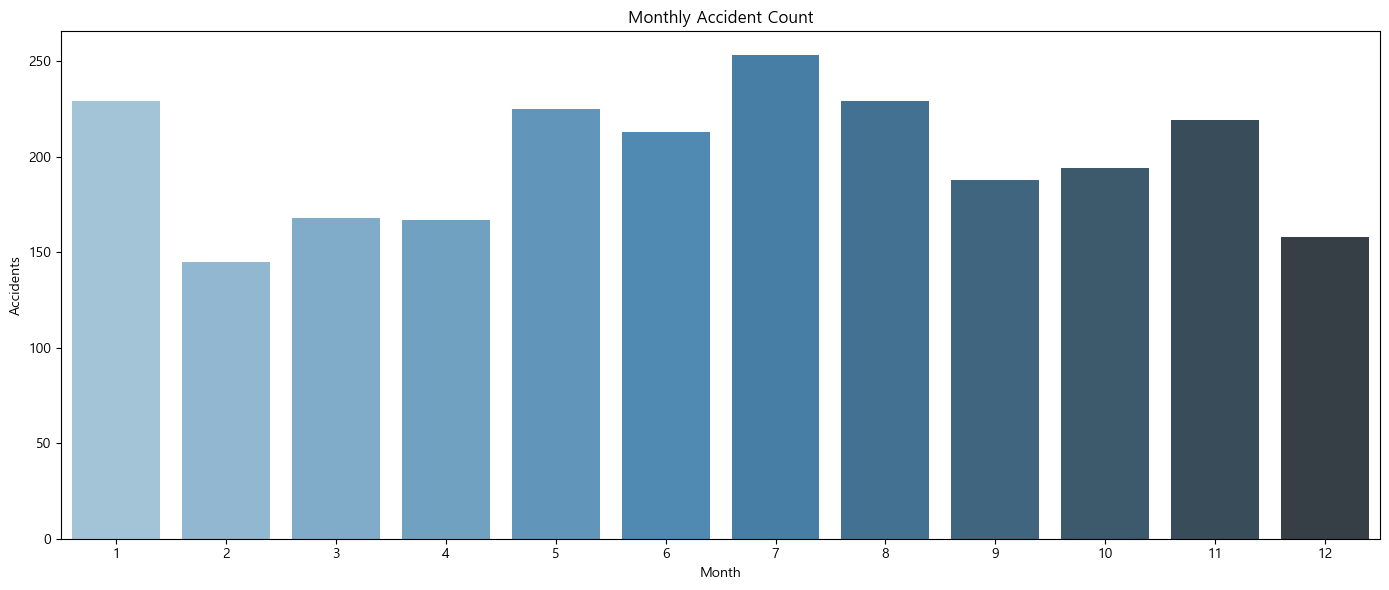

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 6))

# 왼쪽 그래프: 월별 사고건수
sns.barplot(x=monthly_summary.index, y=monthly_summary['사고건수'], palette='Blues_d')
plt.title('Monthly Accident Count')
plt.xlabel('Month')
plt.ylabel('Accidents')


plt.tight_layout()
plt.show()


요일별로

In [ ]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv("서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv", encoding='cp949')

# 날짜 컬럼을 datetime으로 변환
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

# 요일 컬럼 추가
df['요일'] = df['날짜'].dt.day_name()  # 예: Monday, Tuesday 등

# 요일별 데이터 분리 (딕셔너리 형태로 저장)
weekday_data = {day: df[df['요일'] == day] for day in df['요일'].unique()}
weekday_data
# 예시: 월요일 데이터 확인
weekday_data['Monday'].dt.


,연번,날짜,호선,역번호,역명,구분,06시 이전,06시-07시,07시-08시,08시-09시,...,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,24시 이후,요일
4352,4353,2024-01-09,1호선,150,서울역,승차,274,486,1736,2723,...,3741,6841,9641,4142,2867,2737,1638,763,124,Tuesday
4353,4354,2024-01-09,1호선,150,서울역,하차,274,1930,4688,10983,...,2426,2915,2831,1743,1214,1106,713,353,146,Tuesday
4354,4355,2024-01-09,1호선,151,시청,승차,96,118,279,352,...,2172,3846,7647,2651,2405,2063,1226,420,32,Tuesday
4355,4356,2024-01-09,1호선,151,시청,하차,222,845,3499,9186,...,842,875,829,478,278,234,139,90,27,Tuesday
4356,4357,2024-01-09,1호선,152,종각,승차,122,136,243,378,...,2790,6816,10394,4166,3589,3656,2449,1187,94,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4892,2024-01-09,8호선,2826,수진,하차,17,82,143,352,...,326,408,728,502,366,255,194,160,48,Tuesday
4892,4893,2024-01-09,8호선,2827,모란,승차,95,123,374,451,...,513,453,527,242,171,151,118,80,32,Tuesday
4893,4894,2024-01-09,8호선,2827,모란,하차,21,127,170,404,...,258,260,436,210,115,124,96,64,46,Tuesday
4894,4895,2024-01-09,8호선,2828,남위례,승차,71,302,1035,1143,...,346,655,832,298,262,246,187,71,34,Tuesday


In [19]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv("서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv", encoding='cp949')

# 날짜 처리 및 요일 추출
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
df['요일'] = df['날짜'].dt.day_name()

# 시간대 컬럼 추출
time_columns = [col for col in df.columns if '시' in col and '-' in col]

# 요일별 총 유동인구 계산
weekday_passenger_stats = {}
for day in df['요일'].unique():
    wdf = df[df['요일'] == day]
    ride = wdf[wdf['구분'] == '승차'][time_columns].sum()
    exit = wdf[wdf['구분'] == '하차'][time_columns].sum()
    total = ride + exit
    weekday_passenger_stats[day] = total.sum()

# 날짜 수로 나눠서 평균 유동인구 계산
days_per_weekday = df.groupby('요일')['날짜'].nunique()
weekday_avg_passenger = pd.Series(weekday_passenger_stats) / days_per_weekday
weekday_avg_passenger.name = '일평균 유동인구'

# 요일 순서 정리
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg_passenger = weekday_avg_passenger.reindex(weekday_order)

# 출력
weekday_avg_passenger.astype(int)


Monday       9118567
Tuesday      9575765
Wednesday    9399216
Thursday     9659032
Friday       9928125
Saturday     7255252
Sunday       5298546
Name: 일평균 유동인구, dtype: int32

In [23]:
import pandas as pd

# 날짜 처리 및 요일 추출
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
df['요일'] = df['날짜'].dt.day_name()

accident_df['발생일자'] = pd.to_datetime(accident_df['발생일자'], errors='coerce')
accident_df['요일'] = accident_df['발생일자'].dt.day_name()

# 시간대 컬럼
time_columns = [col for col in df.columns if '시' in col and '-' in col]

# 요일별 총 유동인구 계산
weekday_passenger_stats = {}
for day in df['요일'].unique():
    wdf = df[df['요일'] == day]
    ride = wdf[wdf['구분'] == '승차'][time_columns].sum()
    exit = wdf[wdf['구분'] == '하차'][time_columns].sum()
    total = ride + exit
    weekday_passenger_stats[day] = total.sum()

# 요일별 날짜 수
days_per_weekday = df.groupby('요일')['날짜'].nunique()

# 일평균 유동인구
weekday_avg_passenger = pd.Series(weekday_passenger_stats) / days_per_weekday
weekday_avg_passenger.name = '일평균 유동인구'

# 요일별 사고건수
weekday_accidents = accident_df['요일'].value_counts()

# 사고율 계산
weekday_accident_rate = weekday_accidents / weekday_avg_passenger
weekday_accident_rate.name = '사고율'

# 병합
weekday_summary = pd.concat([
    weekday_accidents.rename('사고건수'),
    weekday_avg_passenger,
    weekday_accident_rate
], axis=1)

# 요일 순서 정렬
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_summary = weekday_summary.reindex(weekday_order)
weekday_summary['일평균 유동인구']=weekday_summary['일평균 유동인구'].astype(int)
# 결과 출력
weekday_summary


,사고건수,일평균 유동인구,사고율
Monday,365,9118567,0.000040
Tuesday,382,9575765,0.000040
Wednesday,397,9399216,0.000042
Thursday,409,9659032,0.000042
Friday,397,9928125,0.000040
Saturday,270,7255252,0.000037
Sunday,168,5298546,0.000032


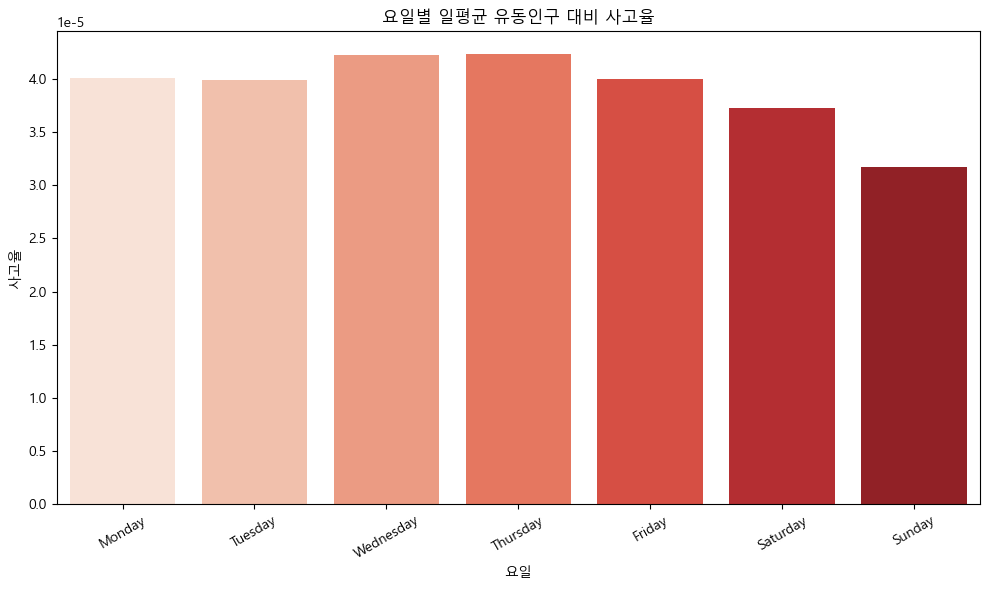

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_summary.index, y=weekday_summary['사고율'], palette='Reds')
plt.title('요일별 일평균 유동인구 대비 사고율')
plt.xlabel('요일')
plt.ylabel('사고율')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
